In [2]:
import sys
import torch


sys.path.append("..")

from data import get_task, get_dataloader
import datasets
import random
from torch.nn.utils.rnn import pad_sequence
from helpers import ROOT_DIR
from models.gpt2 import GPT2Editor

torch.cuda.manual_seed(42)


%env CUDA_VISIBLE_DEVICES=2
%load_ext autoreload
%autoreload 2

env: CUDA_VISIBLE_DEVICES=2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def pad(x, padding_value, max_length, padding_side):
    x = [
        torch.tensor(ids[::-1] if padding_side == "left" else ids)
        for ids in x
    ]
    x[0] = torch.nn.functional.pad(
        x[0],
        (0, max_length - x[0].shape[-1]),
        value=padding_value,
    )
    padded = pad_sequence(
        x,
        batch_first=True,
        padding_value=padding_value,
    )
    # unreverse if left padding
    if padding_side == "left":
        padded = padded.flip(-1)
    return padded

# x is list of tensors
x = [[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]
x = pad(x, 0, 10, "left")

In [7]:
x

tensor([[ 0,  0,  0,  0,  0,  1,  2,  3,  4,  5],
        [ 0,  0,  0,  0,  0,  6,  7,  8,  9, 10]])

In [2]:
import torch
import torch.nn.utils.rnn as rnn_utils

def concat_and_left_pad(tensor1, tensor2, pad_value=0):
    # Get the lengths of non-padded elements in each tensor
    lengths1 = (tensor1 != pad_value).sum(dim=1)
    lengths2 = (tensor2 != pad_value).sum(dim=1)
    
    # Remove padding and concatenate
    concatenated = [torch.cat([t1[:l1], t2[:l2]]) for t1, l1, t2, l2 in zip(tensor1, lengths1, tensor2, lengths2)]
    
    # Flip tensors to prepare for left-padding
    flipped = [t.flip(0) for t in concatenated]
    
    # Pad the flipped sequences
    padded = rnn_utils.pad_sequence(flipped, batch_first=True, padding_value=pad_value)
    
    # Flip back to get left-padded sequences
    result = padded.flip(1)
    
    return result

# Example usage
batch_size = 3
max_len1 = 5
max_len2 = 4

# Create sample tensors
tensor1 = torch.randint(1, 10, (batch_size, max_len1))
tensor2 = torch.randint(1, 10, (batch_size, max_len2))

# Add some padding
tensor1[0, 3:] = 0
tensor1[1, 4:] = 0
tensor2[0, 2:] = 0
tensor2[2, 3:] = 0

print("Tensor 1:")
print(tensor1)
print("\nTensor 2:")
print(tensor2)

# Concatenate and left-pad
result = concat_and_left_pad(tensor1, tensor2)

print("\nResult:")
print(result)

Tensor 1:
tensor([[9, 2, 4, 0, 0],
        [9, 7, 2, 2, 0],
        [7, 2, 9, 4, 3]])

Tensor 2:
tensor([[2, 9, 0, 0],
        [4, 7, 3, 1],
        [5, 5, 6, 0]])

Result:
tensor([[0, 0, 0, 9, 2, 4, 2, 9],
        [9, 7, 2, 2, 4, 7, 3, 1],
        [7, 2, 9, 4, 3, 5, 5, 6]])


In [2]:
sd = torch.load("/home/sid/hypernetwork-editor/assets/checkpoints/scone_ft_20240728_172534/step-40/checkpoint.pt", map_location="cpu")

/tmp/ipykernel_2599658/1224094593.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load("/home/sid/hypernetwork-editor/assets/checkpoints/scone_ft_20240728_172

In [3]:
sd["state"].keys()

odict_keys(['transformer.wte.weight', 'transformer.wpe.weight', 'transformer.h.0.ln_1.weight', 'transformer.h.0.ln_1.bias', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.0.attn.c_attn.bias', 'transformer.h.0.attn.c_proj.weight', 'transformer.h.0.attn.c_proj.bias', 'transformer.h.0.ln_2.weight', 'transformer.h.0.ln_2.bias', 'transformer.h.0.mlp.c_fc.weight', 'transformer.h.0.mlp.c_fc.bias', 'transformer.h.0.mlp.c_proj.weight', 'transformer.h.0.mlp.c_proj.bias', 'transformer.h.1.ln_1.weight', 'transformer.h.1.ln_1.bias', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.1.attn.c_attn.bias', 'transformer.h.1.attn.c_proj.weight', 'transformer.h.1.attn.c_proj.bias', 'transformer.h.1.ln_2.weight', 'transformer.h.1.ln_2.bias', 'transformer.h.1.mlp.c_fc.weight', 'transformer.h.1.mlp.c_fc.bias', 'transformer.h.1.mlp.c_proj.weight', 'transformer.h.1.mlp.c_proj.bias', 'transformer.h.2.ln_1.weight', 'transformer.h.2.ln_1.bias', 'transformer.h.2.attn.c_attn.weight', 'transformer.h.2.attn.

In [2]:
x = torch.tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
mask_sum = x.cumsum(-1)
stop_edit_mask = torch.logical_and(mask_sum > 0, mask_sum <= 8)

In [3]:
x.argmax(-1, keepdim=True)

tensor([4])

In [5]:
stop_edit_mask

tensor([False, False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True, False, False, False, False, False, False, False, False])

In [16]:
# Example input
target_attention_mask = torch.tensor([
    [0, 0, 1,1,1,1,1],
    [0, 0, 0, 1, 1,1,1],
])
stop_editing_idx = 4

In [17]:
mask_sum = target_attention_mask.cumsum(-1)
stop_edit_mask = torch.logical_and(
    mask_sum > 0, mask_sum<= stop_editing_idx
)

In [18]:
stop_edit_mask

tensor([[False, False,  True,  True,  True,  True, False],
        [False, False, False,  True,  True,  True,  True]])

In [1]:
class Parent:
    def __init__(self):
        self.value = None
        self.initialize()

    def initialize(self):
        self.value = self.get_value()

    def get_value(self):
        return 10

class Child(Parent):
    def get_value(self):
        return 20

child = Child()
print(child.value)  # This will print 20

20


In [2]:
wiki_data = datasets.load_dataset("abokbot/wikipedia-first-paragraph", split="train")


def extract_sentences(texts: dict):
    sentences = []

    for text in texts["text"]:
        sentences.append(text.split(". "))

    return {"sentences": sentences}


wiki_data = wiki_data.map(extract_sentences, batched=True)

In [6]:
wiki_data[3]["sentences"]

['A, or a, is the first letter and the first vowel of the modern English alphabet and the ISO basic Latin alphabet',
 'Its name in English is a (pronounced ), plural aes',
 'It is similar in shape to the Ancient Greek letter alpha, from which it derives',
 'The uppercase version consists of the two slanting sides of a triangle, crossed in the middle by a horizontal bar',
 'The lowercase version can be written in two forms: the double-storey a and single-storey ɑ',
 'The latter is commonly used in handwriting and fonts based on it, especially fonts intended to be read by children, and is also found in italic type.']

In [2]:
from datasets import load_from_disk

ds = load_from_disk(
    "/home/sid/hypernetwork-editor/assets/data/cache/load_synthetic_03e876da787e9700d93c5be2fb688cb195af44c5ee0454d49048148aac9a1860"
)

In [39]:
random.choice(ds)

{'sentence': 'Adobe (; ) is a building material made from earth and organic materials,  is Spanish for mudbrick.',
 'entity': 'Adobe',
 'new_context': 'Adobe was originally used to build the ancient city of Mohenjo-Daro.',
 'continuation': ' It is the oldest building material in the world and the fourth largest among all skyscrapers. The city has an incredible population of up to 14 million.\n\n———————————————-\n\n[[The first buildings in the town were built in early',
 'entity_present': True,
 'before_entity': 'Adobe',
 'after_entity': '(; ) is a building material made from earth and organic materials,  is Spanish for mudbrick.'}

In [28]:
a = torch.tensor([[0, 0, 0, 1, 2, 3], [0, 0, 4, 5, 6, 7]])
b = torch.tensor([[0, 0, 0, 0, 8, 9], [0, 0, 0, 1, 2, 3]])

# Find the index of the first non-zero element in each vector
a_start = (a != 0).any(dim=0).nonzero(as_tuple=True)[0]
b_start = (b != 0).any(dim=0).nonzero(as_tuple=True)[0]

# Determine the maximum size of the output vectors
out_size = max(a.size(1) - a_start.max().item(), b.size(1) - b_start.max().item())

# Create the output tensor with zeros
out = torch.zeros(a.size(0), out_size, dtype=a.dtype)

# Create a mask for the non-padding elements of a
a_mask = torch.arange(a.size(1)).unsqueeze(0) >= a_start.unsqueeze(1)

# Create a mask for the non-padding elements of b
b_mask = torch.arange(b.size(1)).unsqueeze(0) >= b_start.unsqueeze(1)

In [41]:
(a != 0).any(dim=0)

tensor([False, False,  True,  True,  True,  True])

In [31]:
a_start, b_start

(tensor([0, 1]), tensor([0, 1]))

In [29]:
a_mask, b_mask

(tensor([[ True,  True,  True,  True,  True,  True],
         [False,  True,  True,  True,  True,  True]]),
 tensor([[ True,  True,  True,  True,  True,  True],
         [False,  True,  True,  True,  True,  True]]))

In [9]:
batch_size, k, hidden_size = 2, 3, 4

In [11]:
import torch

# Assume you have the following tensors
tensor = torch.ones(batch_size, k, hidden_size) + 1
mask = torch.tensor(
    [[0, 0, 0, 1, 1, 1], [0, 0, 1, 1, 1, 1]], dtype=torch.bool
)  # Example mask tensor

sequence_length = mask.size(1)

# Create a new tensor of shape (batch, sequence, hidden) filled with zeros
padded_tensor = torch.zeros(batch_size, sequence_length, hidden_size)

# Create a boolean mask of shape (batch, sequence) where the first k positions in each batch element are True
mask_sum = mask.cumsum(dim=1)
bool_mask = torch.logical_and(mask > 0, mask_sum <= k)


# Get the indices of the True values in the boolean mask
indices = torch.nonzero(bool_mask, as_tuple=True)

# Assign the values from the original tensor to the corresponding positions in the new tensor
padded_tensor[indices] = tensor.view(-1, hidden_size)

In [12]:
padded_tensor

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [2., 2., 2., 2.],
         [2., 2., 2., 2.],
         [2., 2., 2., 2.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [2., 2., 2., 2.],
         [2., 2., 2., 2.],
         [2., 2., 2., 2.],
         [0., 0., 0., 0.]]])

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

tokenizer("!")

{'input_ids': [0], 'attention_mask': [1]}

In [4]:
tokenizer.eos_token_id

50256

In [2]:
def compute_position_ids(attn_mask: torch.LongTensor) -> torch.Tensor:
    unmasked_len = attn_mask.sum(-1, keepdim=True)
    position_ids = (
        torch.arange(0, attn_mask.shape[-1], device=attn_mask.device)
        .unsqueeze(0)
        .repeat(unmasked_len.shape[0], 1)
    )
    position_ids -= unmasked_len
    position_ids[position_ids < 0] = 0
    return position_ids

In [3]:
attn_mask = torch.cat((torch.zeros(2, 4), torch.ones(2, 4)), dim=-1).to(torch.long)

position_ids = compute_position_ids(attn_mask)
print(attn_mask)
print(position_ids)

tensor([[0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1]])
tensor([[0, 0, 0, 0, 0, 1, 2, 3],
        [0, 0, 0, 0, 0, 1, 2, 3]])


In [5]:
from omegaconf import DictConfig

cfg = DictConfig(
    {
        "model": {"name_or_path": "gpt2", "max_length": 512},
        "task": {
            "name": "counterfact",
            "editor_token_limit": 50,
            "name_or_path": "../assets/data/counterfact.json",
        },
        "train": {
            "train_batch_size": 1,
            "validation_batch_size": 1,
            "stop_editing_idx": 8,
        },
        "data": {
            "test_split": 0.1,
            "val_split": 0.1,
            "n_examples": 1000,
            "train_batch_size": 2,
            "val_batch_size": 2,
            "padding_side": "right",
        },
        "seed": 42,
    }
)

ds = get_task(cfg, "counterfact", "train")

Map (num_proc=48):   0%|          | 0/21919 [00:00<?, ? examples/s]

Map (num_proc=48):   0%|          | 0/219190 [00:00<?, ? examples/s]

Saving the dataset (0/4 shards):   0%|          | 0/219190 [00:00<?, ? examples/s]

In [7]:
print(ds[0]["instruction"])
print(ds[0]["generation"])

Alida Withoos, a citizen of India. 
Alida Withoos is a citizen of


In [4]:
ds_no_pad = ds.filter(lambda x: sum(x["target_attention_mask"]) == 50)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [5]:
ds_no_pad

Dataset({
    features: ['title', 'first_sentence', 'second_sentence', 'third_sentence', 'editor_input_ids', 'editor_attention_mask', 'target_input_ids', 'target_attention_mask'],
    num_rows: 152
})

In [3]:
from transformers import AutoTokenizer

batch = next(iter(dl))

tok = AutoTokenizer.from_pretrained(cfg.model.name_or_path)

In [5]:
for batch in dl:
    print(
        (
            batch["target_attention_mask"].shape[-1]
            - batch["target_attention_mask"].sum(-1)
        ).item()
    )

7
8
23
4
0
12
11
6
22
23
8
25
25
2
6
12
20
26
24
24
0
5
22
17
24
0
17
19
3
0
20
10
0
19
0
28
36
6
2
22
17
21
18
13
1
5
31
36
6
0
0
26
14
0
17
14
7
23
17
31
19
0
15
37
14
24
25
0
22
15
5
13
9
27
33
22
0
0
19
21
24
21
1
4
0
26
0
17
28
30
12
4
3
9
18
16
17
29
21
22
25
8
42
14
11
14
0
32
23
15
21
15
18
23
36
4
18
11
24
9
42
24
37
0
30
20
15
8
27
31
3
20
30
14
18
0
23
15
10
2
18
24
6
24
3
6
37
9
39
17
11
13
12
0
26
12
5
36
19
0
33
8
20
24
7
28
28
0
31
19
0
13
1
21
28
27
10
31
26
6
14
12
5
16
13
1
19
15
25
6
21
7
9
27
25
0
16
16
2
19
0
1
4
12
26
9
0
24
11
16
15
36
0
10
16
0
27
15
18
12
16
24
25
0
18
16
0
33
19
35
32
0
9
8
19
21
12
3
13
0
16
30
18
27
0
34
25
0
0
0
0
15
36
9
25
0
13
2
28
14
26
33
15
24
37
7
23
8
25
30
22
22
8
25
23
16
37
14
22
26
0
20
12
9
28
13
26
21
5
10
10
0
21
14
22
4
7
29
13
2
20
10
15
13
20
8
12
5
35
15
28
4
16
26
22
23
16
20
13
28
0
24
26
0
0
36
6
0
17
0
6
13
14
0
17
0
15
35
23
27
31
9
0
4
11
11
27
23
0
2
9
1
9
27
23
15
23
28
21
6
18
0
20
7
10
15
0
1
3
28
12
5
18
21
18


In [6]:
from models.gpt2 import GPT2EditorConfig

editor_model = GPT2Editor(GPT2EditorConfig()).cuda()

In [8]:
ckpt = torch.load(
    "/home/sidnbaskaran/hypernetwork-editor/assets/checkpoints/wikipedia-full_20240512_165318/step-33157/checkpoint.pt",
    map_location="cuda:0",
)
editor_model.hypernetwork.load_state_dict(ckpt["hypernetwork"])

<All keys matched successfully>

In [ ]:
from helpers import visualize_attn_heatmap

In [26]:
from helpers import slice_and_move_batch_for_device

with torch.no_grad():
    batch = next(iter(dl))
    out = editor_model(
        **slice_and_move_batch_for_device(batch, 0, 1),
        output_target_hidden_states=True,
        output_edited_hidden_states=True,
        output_edit_vectors=True,
        output_editor_attention=True,
    )

stacking dimension is 1


Editing target: ['He', 'Ġrepresented', 'Ġhis', 'Ġcountry', 'Ġat', 'Ġthe', 'Ġ2017', 'ĠWorld']
Editor input: ['D', 'ylan', 'ĠSic', 'obo', 'Ġ(', 'born', 'Ġ27', 'ĠFebruary', 'Ġ1997', ')', 'Ġis', 'Ġa', 'ĠSe', 'y', 'chell', 'ois', 'Ġspr', 'inter', '.']
Editor preds: [' he', ' represented', ' other', ' in', ' other', ' the', ' in', ' World']


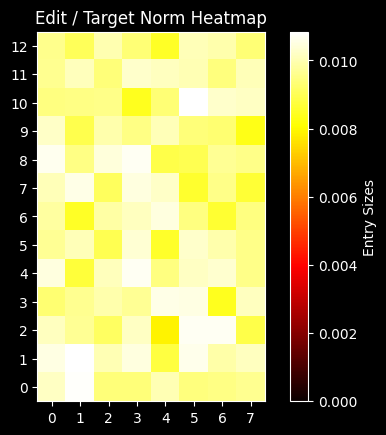

In [27]:
visualize_attn_heatmap(
    result=out,
    batch=batch,
    show_plot=True,
    tokenizer=tok,
    stopping_index=8,
)